### Importing modules

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

### Connecting to db

In [2]:
conn = sqlite3.connect("chinook.db")

In [3]:
def run_query(q):
    return pd.read_sql(q, conn)

In [4]:
def run_command(q):
    conn.cursor().execute(q)

### Checking tables inside db

In [5]:
def show_tables():
    q = "SELECT * FROM sqlite_master WHERE type='table';"
    return run_query(q)

In [6]:
show_tables()

,type,name,tbl_name,rootpage,sql
0,table,album,album,2,CREATE TABLE [album]\n(\n [album_id] INTEGE...
1,table,artist,artist,3,CREATE TABLE [artist]\n(\n [artist_id] INTE...
2,table,customer,customer,4,CREATE TABLE [customer]\n(\n [customer_id] ...
3,table,employee,employee,5,CREATE TABLE [employee]\n(\n [employee_id] ...
4,table,genre,genre,6,CREATE TABLE [genre]\n(\n [genre_id] INTEGE...
5,table,invoice,invoice,7,CREATE TABLE [invoice]\n(\n [invoice_id] IN...
6,table,invoice_line,invoice_line,8,CREATE TABLE [invoice_line]\n(\n [invoice_l...
7,table,media_type,media_type,9,CREATE TABLE [media_type]\n(\n [media_type_...
8,table,playlist,playlist,10,CREATE TABLE [playlist]\n(\n [playlist_id] ...
9,table,playlist_track,playlist_track,11,CREATE TABLE [playlist_track]\n(\n [playlis...


<h3 align="left">Here is the tables schema</h3> 
<img src="https://s3.amazonaws.com/dq-content/190/chinook-schema.svg" alt="Scehma image" style="width: 600px; float:left;"/>

In [7]:
q = '''
WITH total_sold AS (
    SELECT 
        CAST(SUM(il.quantity) AS FLOAT) AS total_qty
    FROM invoice_line AS il
    INNER JOIN invoice AS i ON il.invoice_id = i.invoice_id
    WHERE i.billing_country = "USA"
    )

SELECT
    g.name AS genre,
    SUM(il.quantity) AS tracks_sold_qty,
    SUM(il.quantity) / (SELECT * FROM total_sold) AS tracks_sold_pct
FROM invoice_line AS il
INNER JOIN track AS t ON il.track_id = t.track_id
INNER JOIN genre AS g ON t.genre_id = g.genre_id
INNER JOIN invoice AS i ON il.invoice_id = i.invoice_id
WHERE i.billing_country = "USA"
GROUP BY t.genre_id
ORDER BY 2 DESC
'''
genre_sales_usa = run_query(q)
genre_sales_usa.head(10)

,genre,tracks_sold_qty,tracks_sold_pct
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [8]:
genre_sales_usa = genre_sales_usa.head(10)

### Visualizing genres sales in USA

In [9]:
genre_sales_usa.set_index('genre', inplace=True, drop=True)

In [10]:
genre_sales_usa

,tracks_sold_qty,tracks_sold_pct
genre,,
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253
Alternative,35,0.033302
Latin,22,0.020932
Pop,22,0.020932
Hip Hop/Rap,20,0.019029


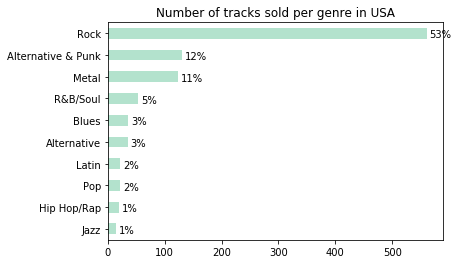

In [11]:
genre_sales_usa['tracks_sold_qty'].plot.barh(
    cmap = plt.cm.Pastel2)

plt.title('Number of tracks sold per genre in USA')
plt.ylabel('')
plt.gca().invert_yaxis()


for i, v in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[v, "tracks_sold_qty"]
    label = (genre_sales_usa.loc[v, "tracks_sold_pct"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score+5, i+0.2))

plt.show()

Recomendation is to go for following genres from proposed:
- Punk
- Blues
- Pop

### Employees sales performance

In [12]:
q = '''
WITH total_customer_purchase AS
    (SELECT
        customer_id,
        SUM(total) AS total
    FROM invoice
    GROUP BY 1)

SELECT
    e.first_name || " " || e.last_name AS employee_name,
    e.hire_date,
    SUM(tcp.total) AS total_sales    
FROM total_customer_purchase AS tcp
INNER JOIN customer AS c ON tcp.customer_id = c.customer_id
LEFT JOIN employee AS e ON c.support_rep_id = e.employee_id
GROUP BY 1
'''

run_query(q)

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


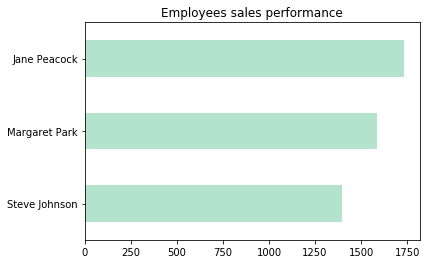

In [13]:
employees_performance = run_query(q)

employees_performance.set_index('employee_name', drop=True, inplace=True)

employees_performance['total_sales'].plot.barh(cmap = plt.cm.Pastel2)
plt.title('Employees sales performance')
plt.ylabel('')
plt.gca().invert_yaxis()

plt.show()

difference in performance can be explained by level of experience of employees (different date of hire)

### Analyzing the sales data for customers from each different country

In [14]:
q = '''
SELECT    
    country,
    CASE 
        WHEN COUNT(customer_id) > 1 THEN country
        ELSE 'Other'
    END AS country2,
    COUNT(customer_id) AS number_of_customers
FROM customer
GROUP BY country
'''

q1 ='''
WITH reviewed_country AS
    (
    SELECT    
        country,
        CASE 
            WHEN COUNT(customer_id) > 1 THEN country
            ELSE 'Other'
        END AS country2,
        COUNT(customer_id) AS number_of_customers
    FROM customer
    GROUP BY country
    )

SELECT
    i.invoice_id,
    i.customer_id,
    rc.country2 AS country,
    i.total
FROM invoice AS i
LEFT JOIN customer AS c ON i.customer_id = c.customer_id
LEFT JOIN reviewed_country AS rc ON c.country = rc.country 
'''

run_query(q1)

,invoice_id,customer_id,country,total
0,1,18,USA,15.84
1,2,30,Canada,9.90
2,3,40,France,1.98
3,4,18,USA,7.92
4,5,27,USA,16.83
5,6,31,Canada,1.98
6,7,49,Other,10.89
7,8,59,India,9.90
8,9,18,USA,8.91
9,10,31,Canada,1.98


In [15]:
q3 = '''
SELECT
    c.customer_id
FROM customer AS c
LEFT JOIN invoice AS i ON i.customer_id = c.customer_id
'''
run_query(q3)

,customer_id
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1
